In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
files_list = []
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    files_list.append(file_name[41:])
    file_name = 'data1/' + file_name[41:]

    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [0]:
# document length
sources['length'] = sources['tokens_lemmatized'].apply(lambda x: len(x))

In [56]:
sources

,file_name,file_content,tokens,tokens_prep,tokens_prep_nostop,tokens_lemmatized,length
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,anno xvn «(ORNALE ITALIANO FATTO PER GL'ITALI...,"[anno, xvn, «, (, ORNALE, ITALIANO, FATTO, PER...","[anno, ornale, italiano, fatto, ithk, first, i...","[ornale, italiano, ithk, first, itauan, daily,...","[ornale, italiano, ithk, first, itauan, daily,...",1425
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,ANNO XVII OtONNAU* ITALIANO PATTO PCP OUTTAUA...,"[ANNO, XVII, OtONNAU*, ITALIANO, PATTO, PCP, O...","[anno, xvii, italiano, patto, outtauani, pirst...","[xvii, italiano, patto, outtauani, pirst, ital...","[xvii, italiano, patto, outtauani, pirst, ital...",1605
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,ANNO XVII GIORNALE ITALIANO FATTO PER GL’ITAL...,"[ANNO, XVII, GIORNALE, ITALIANO, FATTO, PER, G...","[anno, xvii, giornale, italiano, fatto, italia...","[xvii, giornale, italiano, italiani, first, it...","[xvii, giornale, italiano, italiano, first, it...",1179
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,anno xvn GIORNALE ITALIANO FATTO PER GL'ITALI...,"[anno, xvn, GIORNALE, ITALIANO, FATTO, PER, GL...","[anno, giornale, italiano, fatto, first, itali...","[giornale, italiano, first, italian, daily, pa...","[giornale, italiano, first, italian, daily, pa...",1125
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,aXNO XVII GIORNALE ITALIANO FATTO PER GL'ITAL...,"[aXNO, XVII, GIORNALE, ITALIANO, FATTO, PER, G...","[axno, xvii, giornale, italiano, fatto, first,...","[axno, xvii, giornale, italiano, first, italia...","[axno, xvii, giornale, italiano, first, italia...",715
...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,GIORNALE ITALIANO FATTO PER GLITALIA* TMC FIR...,"[GIORNALE, ITALIANO, FATTO, PER, GLITALIA*, TM...","[giornale, italiano, fatto, first, italian, da...","[giornale, italiano, first, italian, daily, pa...","[giornale, italiano, first, italian, daily, pa...",375
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,t (ORNALE ITALIANO FATTO PER OLITALIA* THE FI...,"[t, (, ORNALE, ITALIANO, FATTO, PER, OLITALIA*...","[ornale, italiano, fatto, first, italian, dail...","[ornale, italiano, first, italian, daily, pape...","[ornale, italiano, first, italian, daily, pape...",1270
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,««ORNALE ITALIANO FATTO FER OL'ITAUA* THE FIR...,"[«, «, ORNALE, ITALIANO, FATTO, FER, OL'ITAUA*...","[ornale, italiano, fatto, first, italian, dail...","[ornale, italiano, first, italian, daily, pare...","[ornale, italiano, first, italian, daily, pare...",1401
98,2012271201_1903-08-08_ed-1_seq-1_ocr.txt,Ciac vtj'y inn NUMERO 10 Ebdomadario anarchic...,"[Ciac, vtj'y, inn, NUMERO, 10, Ebdomadario, an...","[ciac, numero, ebdomadario, anarchico, propaga...","[ciac, numero, ebdomadario, anarchico, propaga...","[ciac, numerare, ebdomadario, anarchico, propa...",701


In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# the 2 cells below shouldn't be useful anymore
# for verification purposes later, count the nr of characters for each content
#sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
#sources['file_len'].sum()

In [0]:

# variable containing all documents together
#all_texts = ''
#for i in range(len(sources)):
#all_texts += sources['file_content'][i]
# check length
#len(all_texts)

## 1.2 Removing stop words, punctuation, short words

In [0]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# add new column in df with processed tokens
sources['tokens_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalnum() and len(w) > 3 )])

In [0]:
# these lines are useful if we want to provide alternate stop words lists (NLTK)
# show list of default NLTK Italian stopwords
# stopwords.words('italian')
# ital_stopwords = stopwords.words('italian')
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
import spacy
from spacy.lang.it.stop_words import STOP_WORDS

In [0]:
spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['tokens_prep_nostop'] = sources['tokens_prep'].apply(lambda x: [w for w in x if not w in spacy_it_sw])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['tokens_stemmed'] = sources['tokens_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
%%capture
!python -m spacy download it_core_news_sm

In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['tokens_lemmatized'] = sources['tokens_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['tokens_lemmatized']

# 2. Topics with LDA

In [0]:
%%capture
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [0]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# list of words and occurence per document
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [29]:
# sort descending
words_frequency.sort_values(by=['frequency'], ascending=False)[:10]

,word,frequency
68,1902,5
48,1902,4
78,1902,3
5,1902,3
26,1903,2
75,abitare,2
20,1903,2
66,abitare,2
63,1903,2
2,accogliere,2


## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 6

### 2.2.1 LDA with Gensim

In [0]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [32]:
ldagensim.print_topics()

[(0,
  '0.007*"italiano" + 0.004*"italia" + 0.003*"dispaccio" + 0.003*"roma" + 0.003*"telegrafico" + 0.002*"potere" + 0.002*"daily" + 0.002*"cardinale" + 0.002*"venire" + 0.002*"giornale"'),
 (1,
  '0.006*"italiano" + 0.004*"roma" + 0.003*"telegrafico" + 0.003*"dispaccio" + 0.003*"cardinale" + 0.003*"venire" + 0.003*"italia" + 0.002*"daily" + 0.002*"giornale" + 0.002*"potere"'),
 (2,
  '0.006*"italiano" + 0.003*"dispaccio" + 0.003*"italia" + 0.003*"roma" + 0.002*"potere" + 0.002*"daily" + 0.002*"telegrafico" + 0.002*"dovere" + 0.002*"giornale" + 0.002*"cardinale"'),
 (3,
  '0.009*"italiano" + 0.004*"italia" + 0.004*"roma" + 0.003*"dispaccio" + 0.003*"telegrafico" + 0.003*"daily" + 0.003*"venire" + 0.003*"potere" + 0.003*"giornale" + 0.003*"cardinale"'),
 (4,
  '0.006*"italiano" + 0.004*"dispaccio" + 0.004*"telegrafico" + 0.003*"venire" + 0.003*"italia" + 0.003*"potere" + 0.002*"roma" + 0.002*"daily" + 0.002*"giornale" + 0.002*"gran"'),
 (5,
  '0.010*"italiano" + 0.004*"italia" + 0.004*

### 2.2.2 Visualize topics

In [0]:
# pyLDAvis installation
%%capture
! pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

In [0]:
# insert the model and number of topics you want to visualise
# here LDA Gensim with 6 topics
%%capture
numtopics = 6
selected_model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(selected_model, corpus, id2word)

In [35]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.004153  0.001208       1        1  37.229431
4      0.004662 -0.000829       2        1  32.140408
1     -0.000601  0.002343       3        1  16.226177
3     -0.004312  0.003596       4        1   7.595126
2     -0.000659 -0.001830       5        1   5.537324
0     -0.003244 -0.004488       6        1   1.271536, topic_info=           Term        Freq       Total Category  logprob  loglift
458    italiano  974.000000  974.000000  Default  30.0000  30.0000
456      italia  491.000000  491.000000  Default  29.0000  29.0000
278   dispaccio  474.000000  474.000000  Default  28.0000  28.0000
802        roma  475.000000  475.000000  Default  27.0000  27.0000
995      venire  358.000000  358.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
270        dire    2.256276  237.579575   Topic6  -6.5815  -0.2918
401        gran    2.119362  204.621201   Topic6  -6.6441  -0.2051
677    popolare    1.791339  136.808655   Topic6  -6.8122   0.0293
1023       york    1.964222  216.234360   Topic6  -6.7201  -0.3363
1007   visitare    1.792238  154.980850   Topic6  -6.8117  -0.0949

[556 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
19380      1  0.268801  abolizione
19380      2  0.268801  abolizione
19380      3  0.268801  abolizione
26251      2  0.588165       acena
5049       1  0.344928  acquistare
...      ...       ...         ...
1027       2  0.387547       zione
1027       3  0.172243       zione
1027       4  0.086121       zione
1027       5  0.043061       zione
1027       6  0.008612       zione

[1303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 2, 4, 3, 1])

### 2.2.3 LDA with Mallet

In [0]:
%%capture
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

In [37]:
ldamallet.print_topics()

[(0,
  '0.010*"leggere" + 0.009*"potere" + 0.006*"perchè" + 0.005*"volere" + 0.005*"diritto" + 0.005*"comune" + 0.005*"società" + 0.004*"credere" + 0.004*"mettere" + 0.004*"sociale"'),
 (1,
  '0.019*"cardinale" + 0.015*"papa" + 0.009*"roma" + 0.009*"italiano" + 0.008*"chiesa" + 0.007*"pontefice" + 0.007*"vaticano" + 0.006*"venire" + 0.006*"nome" + 0.006*"leone"'),
 (2,
  '0.007*"giugno" + 0.007*"dispaccio" + 0.006*"partire" + 0.005*"regina" + 0.005*"mentire" + 0.005*"ufficiale" + 0.004*"telegrafico" + 0.004*"vivo" + 0.004*"ministero" + 0.004*"notizia"'),
 (3,
  '0.022*"italiano" + 0.012*"italia" + 0.010*"potere" + 0.007*"unito" + 0.006*"americano" + 0.006*"york" + 0.006*"pubblicare" + 0.005*"america" + 0.005*"venire" + 0.005*"grande"'),
 (4,
  '0.015*"dispaccio" + 0.008*"telegrafico" + 0.008*"gran" + 0.008*"maggio" + 0.008*"giornale" + 0.006*"numerare" + 0.005*"recere" + 0.005*"nuovo" + 0.005*"tenere" + 0.005*"operare"'),
 (5,
  '0.019*"italiano" + 0.015*"roma" + 0.012*"italia" + 0.007

In [0]:
#create variable to retranslate model to Gensim, to be able to compute distribution at a later stage
ldamallet_to_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

### 2.3.1 Coherence score LDA Gensim

In [0]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.30392213382444927


### 2.3.1 Coherence score LDA Mallet


In [0]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score LDA MAllet: ', coherence_ldamallet)


Coherence Score LDA MAllet:  0.37185461721664453


## 2.4 Coherence and number of topics

### 2.4.1 LDA Gensim

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(2, 20):
  model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [0]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 2  has Coherence Value of 0.2918
Num Topics = 3  has Coherence Value of 0.2965
Num Topics = 4  has Coherence Value of 0.2846
Num Topics = 5  has Coherence Value of 0.2831
Num Topics = 6  has Coherence Value of 0.2919
Num Topics = 7  has Coherence Value of 0.2959
Num Topics = 8  has Coherence Value of 0.2975
Num Topics = 9  has Coherence Value of 0.2918
Num Topics = 10  has Coherence Value of 0.2879
Num Topics = 11  has Coherence Value of 0.2929
Num Topics = 12  has Coherence Value of 0.2934
Num Topics = 13  has Coherence Value of 0.2894
Num Topics = 14  has Coherence Value of 0.2953
Num Topics = 15  has Coherence Value of 0.2875
Num Topics = 16  has Coherence Value of 0.2896
Num Topics = 17  has Coherence Value of 0.2884
Num Topics = 18  has Coherence Value of 0.2892
Num Topics = 19  has Coherence Value of 0.2925


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

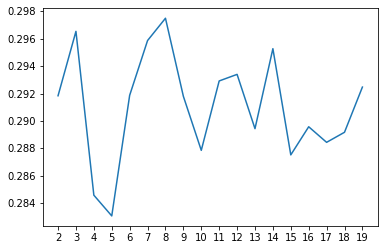

In [0]:
plt.plot(topics_nr, coherence_values_gensim)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 7
%%capture
numtopics = 7
model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics)

In [0]:
model.print_topics()

[(0,
  '0.008*"italiano" + 0.003*"telegrafico" + 0.003*"dispaccio" + 0.003*"italia" + 0.003*"venire" + 0.003*"roma" + 0.003*"daily" + 0.003*"giornale" + 0.002*"nuovo" + 0.002*"potere"'),
 (1,
  '0.007*"italiano" + 0.005*"italia" + 0.004*"dispaccio" + 0.003*"roma" + 0.003*"giornale" + 0.003*"daily" + 0.002*"venire" + 0.002*"telegrafico" + 0.002*"potere" + 0.002*"gran"'),
 (2,
  '0.006*"italiano" + 0.004*"italia" + 0.004*"telegrafico" + 0.003*"dispaccio" + 0.003*"roma" + 0.003*"venire" + 0.003*"potere" + 0.002*"giornale" + 0.002*"york" + 0.002*"cardinale"'),
 (3,
  '0.008*"italiano" + 0.004*"roma" + 0.004*"italia" + 0.004*"dispaccio" + 0.003*"potere" + 0.003*"venire" + 0.003*"telegrafico" + 0.002*"daily" + 0.002*"cardinale" + 0.002*"giornale"'),
 (4,
  '0.008*"italiano" + 0.005*"roma" + 0.004*"italia" + 0.004*"potere" + 0.003*"dispaccio" + 0.003*"telegrafico" + 0.003*"giornale" + 0.002*"daily" + 0.002*"mentire" + 0.002*"venire"'),
 (5,
  '0.008*"italiano" + 0.004*"italia" + 0.003*"daily"

### 2.4.2 LDA Mallet

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_mallet = []
for num_topics in range(2, 20):
  model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_mallet.append(coherence_value)
  topics_nr.append(str(num_topics))

In [0]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_mallet[i],4))

Num Topics = 2  has Coherence Value of 0.3064
Num Topics = 3  has Coherence Value of 0.3695
Num Topics = 4  has Coherence Value of 0.3703
Num Topics = 5  has Coherence Value of 0.3871
Num Topics = 6  has Coherence Value of 0.3947
Num Topics = 7  has Coherence Value of 0.3802
Num Topics = 8  has Coherence Value of 0.3892
Num Topics = 9  has Coherence Value of 0.3845
Num Topics = 10  has Coherence Value of 0.4145
Num Topics = 11  has Coherence Value of 0.3954
Num Topics = 12  has Coherence Value of 0.3799
Num Topics = 13  has Coherence Value of 0.3507
Num Topics = 14  has Coherence Value of 0.3777
Num Topics = 15  has Coherence Value of 0.373
Num Topics = 16  has Coherence Value of 0.3585
Num Topics = 17  has Coherence Value of 0.3684
Num Topics = 18  has Coherence Value of 0.3705
Num Topics = 19  has Coherence Value of 0.368


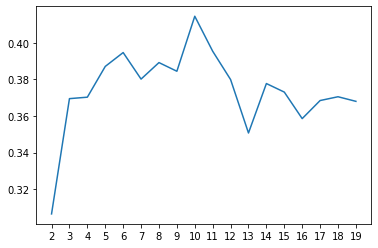

In [0]:
plt.plot(topics_nr, coherence_values_mallet)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [0]:
# print topics for nr of topics = 10
%%capture
numtopics = 10
model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

In [0]:
model.print_topics()

[(0,
  '0.030*"cardinale" + 0.024*"papa" + 0.011*"pontefice" + 0.011*"roma" + 0.010*"leone" + 0.010*"chiesa" + 0.010*"xiii" + 0.010*"conclave" + 0.009*"italiano" + 0.008*"vaticano"'),
 (1,
  '0.014*"italiano" + 0.007*"vivo" + 0.007*"bandiera" + 0.006*"venezia" + 0.005*"azione" + 0.005*"sentire" + 0.005*"scrivere" + 0.005*"studente" + 0.005*"storia" + 0.004*"patrio"'),
 (2,
  '0.013*"potere" + 0.012*"leggere" + 0.007*"nuovo" + 0.007*"comune" + 0.006*"sociale" + 0.006*"passare" + 0.006*"popolare" + 0.005*"lottare" + 0.005*"classe" + 0.005*"perchè"'),
 (3,
  '0.016*"italiano" + 0.014*"telegrafico" + 0.011*"giornale" + 0.009*"grave" + 0.008*"francese" + 0.008*"dispaccio" + 0.008*"parigi" + 0.008*"presidente" + 0.007*"parlare" + 0.007*"daily"'),
 (4,
  '0.010*"gran" + 0.009*"morto" + 0.009*"dovere" + 0.008*"recere" + 0.008*"ebreo" + 0.008*"dispaccio" + 0.007*"maggio" + 0.007*"polizia" + 0.006*"fatto" + 0.006*"popolare"'),
 (5,
  '0.019*"venire" + 0.012*"trovare" + 0.011*"dare" + 0.011*"dire

# Topic distribution

## 3.1. Gensim

### 3.1.1. Distribution per topic and per document

In [0]:
%%capture
numtopics = 6
ldamodel = models.LdaModel(corpus, num_topics=numtopics, id2word = id2word, minimum_probability=0)

In [0]:
distribution_gensim = pd.DataFrame(index=[i for i in range(len(corpus))],columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
#lda.get_document_topics

for i in range(len(corpus)):
  row = [list(j)[1] for j in ldamodel.get_document_topics(corpus[i]) ]
  distribution_gensim.loc[i] = row

#for i in range(len(corpus)):
#  row = [list(j)[1] for j in ldamodel[corpus[i]]] 
#  distribution_gensim.loc[i] = row

In [0]:
#testing
# ldamodel[corpus[0]]

In [0]:
# ldamodel.get_document_topics(corpus[0])

In [0]:
# add file name
distribution_gensim.insert(0, 'document_path', sources['file_name'])

In [46]:
distribution_gensim

,document_path,topic0,topic1,topic2,topic3,topic4,topic5
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.000118036,0.0761749,0.000117948,0.000117974,0.919603,0.00386832
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.000104789,0.999476,0.000104644,0.000104705,0.000104742,0.00010474
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.000142584,0.999287,0.0001423,0.000142437,0.000142539,0.000142664
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.0169658,0.0318278,0.000149266,0.000149533,0.429305,0.521603
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.000234771,0.998826,0.000234457,0.00023474,0.000235312,0.00023487
...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.000446949,0.000446986,0.000447329,0.000447503,0.074258,0.923953
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.00341992,0.171616,0.0330712,0.00202496,0.647128,0.142739
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.333984,0.000120043,0.0354564,0.00011996,0.500432,0.129888
98,2012271201_1903-08-08_ed-1_seq-1_ocr.txt,0.000239636,0.63149,0.000239138,0.000239433,0.367553,0.000239362


### 3.1.2. Distribution per topic for the whole corpus

In [0]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
from scipy.sparse import issparse


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim

    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
    # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary),\
        'Term frequencies and dictionary have different shape {} != {}'.format(
        term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus),\
        'Document lengths and corpus have different sizes {} != {}'.format(
        doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics,\
        'Document topics and number of topics do not match {} != {}'.format(
        doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    return {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
            'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}


In [0]:
%%capture
ldamodel = models.LdaModel(corpus, num_topics=numtopics, id2word = id2word, minimum_probability=0)

In [51]:
_extract_data(ldamodel, corpus=corpus, dictionary=id2word, doc_topic_dists=None)

{'doc_lengths': array([1425., 1605., 1179., 1125.,  715., 1599., 1663., 1507., 1062.,
        1189., 1473., 1401.,  894., 1090., 1245., 1089.,  934., 1008.,
        1582., 1450., 1607., 1352., 1181., 1605., 1539., 1166., 1507.,
        1562., 1586., 1213., 1611., 1339., 1494., 1596., 1588.,  658.,
        1494., 1476., 1776., 1539., 1442.,  918.,  738., 1629., 1141.,
        1208., 1582., 1219., 1380.,  742., 1056., 1369., 1632., 1372.,
        1409., 1494.,  749., 1492., 1471., 1411., 1703., 1526., 1579.,
         784., 1742.,  968., 1113.,  937., 1506., 1618.,    2., 1335.,
        1495., 1567., 1208., 1540., 1573.,  758., 1528., 1069.,  920.,
         897.,  951., 1656.,  709., 1218., 1135., 1191., 1180., 1420.,
        1525.,  751., 1529., 1592., 1188.,  375., 1270., 1401.,  701.,
        1309.]),
 'doc_topic_dists': array([[1.18059768e-04, 6.24393055e-04, 6.71128869e-01, 2.36556493e-02,
         1.17884469e-04, 3.04355115e-01],
        [5.62333763e-02, 1.04755825e-04, 2.71526605e-

In [47]:
topics = []
topic_weights = []
for i in range(len(distribution_gensim.columns)-1):
  topic_weight = round(sum(distribution_gensim.iloc[:,i+1]),2)
  topic_weights.append(topic_weight)
  print( f'topic {i}: {topic_weight}%' )
  topic = ldamodel.print_topics()[i][1]
  topics.append(i)
  print( f'terms: {topic} ')

topic 0: 16.75%
terms: 0.007*"italiano" + 0.005*"italia" + 0.004*"dispaccio" + 0.003*"venire" + 0.003*"telegrafico" + 0.003*"roma" + 0.002*"giornale" + 0.002*"daily" + 0.002*"potere" + 0.002*"york" 
topic 1: 39.41%
terms: 0.009*"italiano" + 0.004*"telegrafico" + 0.004*"italia" + 0.004*"dispaccio" + 0.003*"giornale" + 0.003*"roma" + 0.003*"venire" + 0.003*"potere" + 0.003*"daily" + 0.002*"gran" 
topic 2: 3.34%
terms: 0.007*"italiano" + 0.004*"roma" + 0.003*"italia" + 0.003*"telegrafico" + 0.003*"dispaccio" + 0.003*"potere" + 0.003*"daily" + 0.003*"venire" + 0.003*"cardinale" + 0.002*"dovere" 
topic 3: 5.49%
terms: 0.007*"italiano" + 0.004*"dispaccio" + 0.003*"potere" + 0.003*"roma" + 0.003*"italia" + 0.003*"daily" + 0.002*"telegrafico" + 0.002*"giornale" + 0.002*"nuovo" + 0.002*"venire" 
topic 4: 26.39%
terms: 0.009*"italiano" + 0.004*"italia" + 0.004*"roma" + 0.003*"dispaccio" + 0.003*"potere" + 0.003*"cardinale" + 0.003*"telegrafico" + 0.003*"daily" + 0.002*"venire" + 0.002*"giornale"

In [0]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_weights, columns=['weight'])

In [0]:
distribution_df_gensim['topics'] = topics

In [0]:
distribution_df_gensim['topics'] = distribution_df_gensim['topics'].apply(lambda x: f'topic {x}')

In [0]:
distribution_df_gensim = distribution_df_gensim.sort_values(by=['weight'])

Text(0.5, 0, 'Weight (%)')

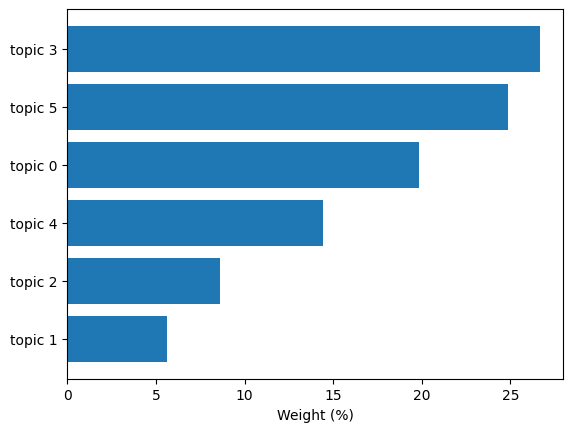

In [0]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(distribution_df_gensim['topics'], distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

##3.2 Mallet

### 3.2.1 Distribution per topic and per document

In [0]:
distribution_mallet = pd.DataFrame(index=[i for i in range(len(corpus))],columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
for i in range(len(corpus)):
  row = [list(j)[1] for j in ldamallet_to_gensim[corpus[i]]] 
  distribution_mallet.loc[i] = row

In [0]:
distribution_mallet.insert(0, 'document_path', sources['file_name'])

In [0]:
# functionalities that are available with mallet wrapper retranslated to gensim need to be investigated further
# ldamallet_to_gensim.print_topics()

In [0]:
distribution_mallet

,document_path,topic0,topic1,topic2,topic3,topic4,topic5
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.231498,0.0727352,0.0829734,0.135047,0.251138,0.226609
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.170117,0.0477283,0.0999062,0.175304,0.334495,0.172449
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.262384,0.0581078,0.0567422,0.233382,0.266629,0.122754
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.348604,0.0669136,0.0541565,0.08167,0.295551,0.153105
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.171465,0.0518164,0.217659,0.231854,0.295513,0.0316928
...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.280612,0.471422,0.0662954,0.0526218,0.0611473,0.0679019
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.185934,0.235344,0.0468113,0.137529,0.173382,0.221
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.322557,0.271309,0.0796197,0.169776,0.0806498,0.0760887
98,2012271201_1903-08-08_ed-1_seq-1_ocr.txt,0.0401617,0.0441725,0.715951,0.102523,0.0514279,0.0457643


### 3.2.2. Distribution per topic for the whole corpus

In [0]:
topics = []
topic_weights = []
for i in range(len(distribution_mallet.columns)-1):
  topic_weight = round(sum(distribution_mallet.iloc[:,i+1]),2)
  topic_weights.append(topic_weight)
  print( f'topic {i}: {topic_weight}%' )
  topic = ldamallet_to_gensim.print_topics()[i][1]
  topics.append(i)
  print( f'terms: {topic} ')

topic 0: 20.56%
terms: 0.000*"lefonica" + 0.000*"consigliera" + 0.000*"identità" + 0.000*"prln" + 0.000*"bhrlino" + 0.000*"derrata" + 0.000*"cecancelllere" + 0.000*"obrenovlch" + 0.000*"nito" + 0.000*"varcare" 
topic 1: 13.04%
terms: 0.000*"termediatl" + 0.000*"glietti" + 0.000*"grandinare" + 0.000*"maremm" + 0.000*"difficilmente" + 0.000*"continuato" + 0.000*"porgervi" + 0.000*"ovvio" + 0.000*"barbabietola" + 0.000*"coraggio" 
topic 2: 14.4%
terms: 0.000*"petè" + 0.000*"itrlllat" + 0.000*"reatty" + 0.000*"schierala" + 0.000*"arrestarsi" + 0.000*"francobollo" + 0.000*"irrito" + 0.000*"lungi" + 0.000*"triplice" + 0.000*"indeterminato" 
topic 3: 14.3%
terms: 0.000*"analisi" + 0.000*"cornicino" + 0.000*"mindanao" + 0.000*"alutantiile" + 0.000*"parlftc" + 0.000*"quay" + 0.000*"gantemente" + 0.000*"promul" + 0.000*"furo7io" + 0.000*"nauseare" 
topic 4: 20.49%
terms: 0.000*"chetti" + 0.000*"herald" + 0.000*"vistili" + 0.000*"albani" + 0.000*"tiro" + 0.000*"budapm8" + 0.000*"rini" + 0.000*"ve

In [0]:
distribution_df_mallet = pd.DataFrame(topic_weights, columns=['weight'])

In [0]:
distribution_df_mallet['topics'] = topics

In [0]:
distribution_df_mallet['topics'] = distribution_df_mallet['topics'].apply(lambda x: f'topic {x}')

In [0]:
distribution_df_mallet = distribution_df_mallet.sort_values(by=['weight'])

Text(0.5, 0, 'Weight (%)')

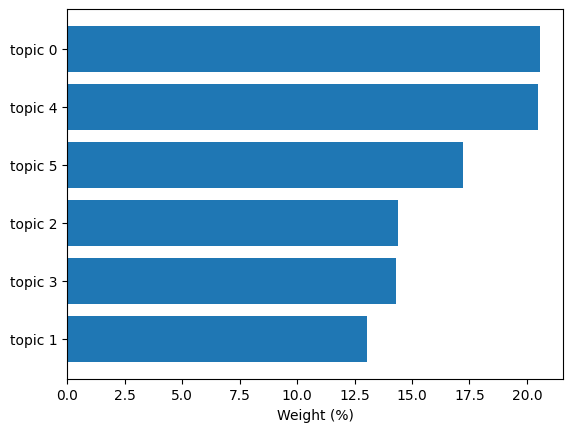

In [0]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(distribution_df_mallet['topics'], distribution_df_mallet['weight'], align='center')
ax.set_xlabel('Weight (%)')

# Topics weight over time

## 4.1 Aggregate document weights

In [0]:
# The goal is to be able to group the data per month

In [0]:
import re

In [0]:
# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

In [0]:
distribution_gensim['date'] = distribution_gensim['document_path'].apply(lambda x: get_date(x))
distribution_gensim['year'] = distribution_gensim['document_path'].apply(lambda x: get_year(x))
distribution_gensim['month'] = distribution_gensim['document_path'].apply(lambda x: get_month(x))

In [0]:
gensim_groupby = distribution_gensim.copy()

In [0]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [0]:
# group by year and month 
distribution_month = gensim_groupby.groupby(['year','month']).sum().reset_index()

In [0]:
distribution_month

,year,month,topic0,topic1,topic2,topic3,topic4,topic5
0,1903,04,1.814085,0.002722,0.018676,0.082127,0.004328,2.078062
1,1903,05,8.405633,1.210830,2.048485,4.514570,1.008324,8.812160
2,1903,06,4.294504,1.799166,3.986612,8.112861,3.056680,8.750177
3,1903,07,5.021850,2.584730,1.566990,10.334144,8.640385,2.851901
4,1903,08,0.287317,0.047695,1.013576,3.603401,1.697857,2.350154


In [0]:
dates = []
for i in range(len(distribution_month)):
  year = distribution_month['year'][i]
  month = distribution_month['month'][i]
  dates.append(f'{month}/{year}')

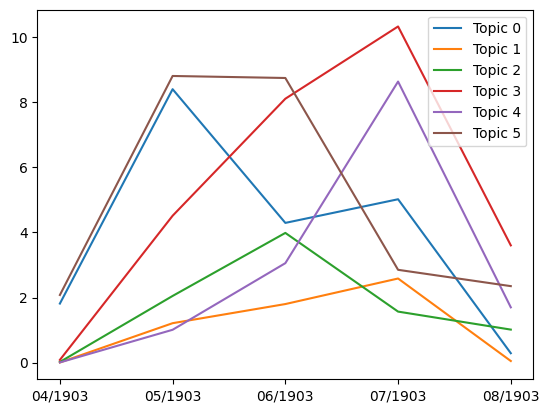

In [0]:
# quick first overview
plt.plot(dates, distribution_month['topic0'], label="Topic 0")
plt.plot(dates, distribution_month['topic1'], label="Topic 1")
plt.plot(dates, distribution_month['topic2'], label="Topic 2")
plt.plot(dates, distribution_month['topic3'], label="Topic 3")
plt.plot(dates, distribution_month['topic4'], label="Topic 4")
plt.plot(dates, distribution_month['topic5'], label="Topic 5")
plt.legend()

## 4.2. Gensim

